In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import errno
import sys




import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import sampler
import torchvision.transforms as T

In [2]:
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
NUM_TRAIN=49000
train_batch_size=4
test_batch_size=4



cifar10_train = torchvision.datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = torch.utils.data.DataLoader(cifar10_train, batch_size=train_batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = torchvision.datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = torch.utils.data.DataLoader(cifar10_val, batch_size=train_batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = torchvision.datasets.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = torch.utils.data.DataLoader(cifar10_test, batch_size=test_batch_size)





Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torchvision.datasets as dset
from PIL import Image    
import os
import os.path
import errno
import sys
import torch

class CIFAR100(dset.CIFAR10):

    base_folder = '.'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    
    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        self.test_data = []
        if self.train:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((5000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            print(self.train_data.shape)
        else:
            f = 'test'
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = np.array(entry['data'])
            if 'labels' in entry:
                self.test_labels = entry['data']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((1000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC
            print(self.test_data.shape)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.astype('uint8')).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)                
            
    def _check_integrity(self):
        return True
    


if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

A_train = CIFAR100('./class1', train=True, download=False,
                             transform=transform)
loaderA_train = torch.utils.data.DataLoader(A_train, batch_size=4)



A_test = CIFAR100('./class1', train=False, download=False,
                             transform=transform)
loaderA_test = torch.utils.data.DataLoader(A_test, batch_size=4)


B_train = CIFAR100('./class2', train=True, download=False,
                             transform=transform)
loaderB_train = torch.utils.data.DataLoader(B_train, batch_size=4)


B_test = CIFAR100('./class2', train=False, download=False,
                             transform=transform)
loaderB_test = torch.utils.data.DataLoader(B_test, batch_size=4)
   


(5000, 32, 32, 3)
(1000, 32, 32, 3)
(5000, 32, 32, 3)
(1000, 32, 32, 3)


In [4]:
class ALL_CNN_C(nn.Module):
    def __init__(self, num_classes=10):
        super (ALL_CNN_C, self).__init__()
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)
        
        self.conv3 = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=0)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.constant_(self.conv3.bias, 0)
        
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv4 = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.constant_(self.conv3.bias, 0)
        
        self.conv5 = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.constant_(self.conv5.bias, 0)
        
        self.conv6 = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.constant_(self.conv6.bias, 0)
        
        self.dropout3 = nn.Dropout(0.5)
        
        self.conv7 = nn.Conv2d(192, 192, kernel_size=3, padding=3)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.constant_(self.conv7.bias, 0)
        
        self.conv8 = nn.Conv2d(192, 192, kernel_size=1)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.constant_(self.conv8.bias, 0)
        
        self.conv9 = nn.Conv2d(192, self.num_classes, kernel_size=1)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.constant_(self.conv9.bias, 0)
        
        self.glb_avg = nn.AvgPool2d(6)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = F.relu(out)
        
        out = self.dropout2(out)
        
        out = self.conv4(out)
        out = F.relu(out)
        
        out = self.conv5(out)
        out = F.relu(out)
        
        out = self.conv6(out)
        out = F.relu(out)
        
        out = self.dropout3(out)
        
        out = self.conv7(out)
        out = F.relu(out)
        
        out = self.conv8(out)
        out = F.relu(out)
        
        out = self.conv9(out)
        out = F.relu(out)
        
        out = self.glb_avg(out)
        out = out.view(-1, self.num_classes)
        return out
import new_ALL_Conv


right


In [14]:
from six.moves import cPickle
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import sampler

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples *100
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples,  acc))
    return acc*100

def running_model_B(run_num, net, net_name, lr_list, epoch_list, loader_train, 
                   loader_test):
    train_batch_size = 4
    test_batch_size = 4
    

    # Constant to control how frequently we print train loss
    print_every = 100

    print('using device:', device)
    
    #net = BaseNet_A()
    net = net.to(device=device)
    criterion = nn.CrossEntropyLoss()        
        
    lr_1, lr_2, lr_3, lr_4 = lr_list[0], lr_list[1], lr_list[2], lr_list[3]
    weight_decay = 0.001

    max_epoch = 350
    display_interval = 500

    train_size = 5000
    test_size = 1000

    num_train_batch = train_size/train_batch_size
    num_test_batch = test_size/test_batch_size

    train_loss = np.zeros((max_epoch,1))
    val_acc = np.zeros((max_epoch,1))
    #train_acc = np.zeros((max_epoch,1))
    #test_loss = np.zeros((max_epoch,1))
    #test_acc = np.zeros((max_epoch,1))

    epoch_acc = [] # max_epoch x num
    print("begin training")
    for epoch in range(max_epoch):
        if(epoch<epoch_list[0]):
            lr = lr_1
        elif(epoch<epoch_list[1]):
            lr = lr_2
        elif(epoch<epoch_list[2]):
            lr = lr_3
        else:
            lr = lr_4
    
        optimizer = optim.SGD( net.parameters(), lr=0.001,
                              momentum=0.9, weight_decay=weight_decay)
    
        running_epoch_loss = 0.
        running_loss_print = 0.
        epoch_total_num = 0
        correct_num = 0
    
        i_acc = []
        #for i, data in enumerate(trainloader):
        for i, data in enumerate(loader_train):
            net.train()
        
            inputs_data, labels_data = data
            inputs, labels = Variable(inputs_data), Variable(labels_data)
            inputs = inputs.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
        
    
        
        
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_epoch_loss += loss.item()
            running_loss_print += loss.item()
            if i%500 == 499: #net a, b, c 500 print once
                
                acc = check_accuracy(loader_test, net)
                i_acc.append(acc)
                print('%d epoch, %5d iteration, loss:%.3f' 
                      %(epoch+1, i+1, running_loss_print/500) )
                running_loss_print = 0.
            
            #_, pred = torch.max(outputs, 1)
            #epoch_total_num += labels.size(0)
            #correct_num += (pred==labels).sum()
        
        
        train_loss[epoch] = running_epoch_loss/num_train_batch
        epoch_acc.append(i_acc)
        
        val_acc[epoch] = np.sum(epoch_acc[epoch])/49
        #val_acc[epoch] = np.sum(epoch_acc[epoch])
        #train_acc[epoch] = correct_num/epoch_total_num*100
    
    
        # test accuracy and loss
        '''
        ts_runningloss_epoch = 0.
        ts_correct = 0
        ts_epoch_num = 0
        for data in testloader:
            inputs_data, labels_data = data
            inputs, labels = Variable(inputs_data), Variable(labels_data)
            inputs = inputs.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
        
            net.eval()
            ts_outputs = net(inputs)
            loss = criterion(outputs, labels)
        
            ts_runningloss_epoch += loss.item()
            _, ts_pred = torch.max(ts_outputs, 1)
        
            ts_epoch_num += labels.size(0)
            ts_correct += (ts_pred==labels).sum()
        test_loss[epoch] = ts_runningloss_epoch/num_test_batch
        test_acc[epoch] = ts_correct/ts_epoch_num*100
        '''
        print(" num %d epoch " %epoch)
        print("####### Training Loss #######")
        print(train_loss[epoch])
        #print("####### Validation Accuracy #######")
        #print(val_acc[epoch])
        #print("####### Training Accuracy #######")
        #print(train_acc[epoch])
        #print("####### Testing Loss #######")
        #print(test_loss[epoch])
        #print("####### Testing Accuracy #######")
        #print(test_acc[epoch])
    
    print('finish training \n')

    



##################################################################################################
    print('now begin saving datum for next step plotting')
    
    save_path = '../datum_for_plotting/run_num_' + str(run_num)+'/'+ net_name
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    f = open(save_path + '/train_loss.save', 'wb')
    cPickle.dump(train_loss, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    f = open(save_path + '/val_acc.save', 'wb')
    cPickle.dump(val_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    f = open(save_path + '/epoch_acc.save', 'wb')
    cPickle.dump(epoch_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    array_epoch_acc = np.array(epoch_acc)
    f = open(save_path + '/array_epoch_acc.save', 'wb')
    cPickle.dump(array_epoch_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    #f = open(save_path + '/test_acc.save', 'wb')
    #cPickle.dump(test_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    #f.close()



    torch.save(net, save_path+'/'+ net_name +'.pkl') # save whole net structure and params
    torch.save(net.state_dict, save_path+'/'+ net_name +'_params.pkl') # only save model params
 
    
    
    
##################################################################################################    
    print("now plotting accuracies and losses")  
    itern_axis_train = np.array(np.linspace(1,max_epoch,num=max_epoch))
    itern_axis_test = np.array(np.linspace(1,max_epoch, num=max_epoch))

    plt.plot(itern_axis_train, train_loss,'-b.', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.savefig(save_path + '/train_loss' + str(max_epoch) + '.png')
    
    a = np.concatenate(array_epoch_acc)
    length = a.shape[0]
    plt.plot(length, a, '--r', label='Test')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.savefig(save_path + '/testing_accuracy' + str(max_epoch) + '.png')
    
    return net

    

In [6]:
lr = [0.01, 0.005, 0.001, 0.0005]
epoch = [200, 250, 300] # first20

run_num = 10
net_name = 'ALL_CNN_C_Class1'

torch.cuda.set_device(0)

all_cnn_c_class1 = running_model_B(run_num, all_cnn_c_class1, net_name, lr, epoch, 
                        loaderA_train, loaderA_test)

using device: cuda
begin training
Checking accuracy on test set
Got 199 / 1000 correct (19.90)
1 epoch,   500 iteration, loss:2.288
Checking accuracy on test set
Got 258 / 1000 correct (25.80)
1 epoch,  1000 iteration, loss:2.245
 num 0 epoch 
####### Training Loss #######
[2.2496775]
Checking accuracy on test set
Got 266 / 1000 correct (26.60)
2 epoch,   500 iteration, loss:2.107
Checking accuracy on test set
Got 309 / 1000 correct (30.90)
2 epoch,  1000 iteration, loss:2.067
 num 1 epoch 
####### Training Loss #######
[2.0645971]
Checking accuracy on test set
Got 306 / 1000 correct (30.60)
3 epoch,   500 iteration, loss:1.978
Checking accuracy on test set
Got 360 / 1000 correct (36.00)
3 epoch,  1000 iteration, loss:1.931
 num 2 epoch 
####### Training Loss #######
[1.93003855]
Checking accuracy on test set
Got 337 / 1000 correct (33.70)
4 epoch,   500 iteration, loss:1.854
Checking accuracy on test set
Got 394 / 1000 correct (39.40)
4 epoch,  1000 iteration, loss:1.827
 num 3 epoch 

Got 667 / 1000 correct (66.70)
33 epoch,   500 iteration, loss:0.599
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
33 epoch,  1000 iteration, loss:0.575
 num 32 epoch 
####### Training Loss #######
[0.56951155]
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
34 epoch,   500 iteration, loss:0.577
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
34 epoch,  1000 iteration, loss:0.578
 num 33 epoch 
####### Training Loss #######
[0.5596024]
Checking accuracy on test set
Got 674 / 1000 correct (67.40)
35 epoch,   500 iteration, loss:0.553
Checking accuracy on test set
Got 673 / 1000 correct (67.30)
35 epoch,  1000 iteration, loss:0.535
 num 34 epoch 
####### Training Loss #######
[0.53640391]
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
36 epoch,   500 iteration, loss:0.529
Checking accuracy on test set
Got 674 / 1000 correct (67.40)
36 epoch,  1000 iteration, loss:0.511
 num 35 epoch 
####### Training Loss #######
[0.5012605]
Checking

Checking accuracy on test set
Got 695 / 1000 correct (69.50)
65 epoch,  1000 iteration, loss:0.202
 num 64 epoch 
####### Training Loss #######
[0.19070092]
Checking accuracy on test set
Got 677 / 1000 correct (67.70)
66 epoch,   500 iteration, loss:0.176
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
66 epoch,  1000 iteration, loss:0.199
 num 65 epoch 
####### Training Loss #######
[0.19159108]
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
67 epoch,   500 iteration, loss:0.211
Checking accuracy on test set
Got 660 / 1000 correct (66.00)
67 epoch,  1000 iteration, loss:0.189
 num 66 epoch 
####### Training Loss #######
[0.2094313]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
68 epoch,   500 iteration, loss:0.219
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
68 epoch,  1000 iteration, loss:0.186
 num 67 epoch 
####### Training Loss #######
[0.19054151]
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
69 epoch,   500

Got 671 / 1000 correct (67.10)
97 epoch,  1000 iteration, loss:0.097
 num 96 epoch 
####### Training Loss #######
[0.10764187]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
98 epoch,   500 iteration, loss:0.108
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
98 epoch,  1000 iteration, loss:0.115
 num 97 epoch 
####### Training Loss #######
[0.11585148]
Checking accuracy on test set
Got 643 / 1000 correct (64.30)
99 epoch,   500 iteration, loss:0.125
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
99 epoch,  1000 iteration, loss:0.097
 num 98 epoch 
####### Training Loss #######
[0.11002209]
Checking accuracy on test set
Got 709 / 1000 correct (70.90)
100 epoch,   500 iteration, loss:0.106
Checking accuracy on test set
Got 657 / 1000 correct (65.70)
100 epoch,  1000 iteration, loss:0.111
 num 99 epoch 
####### Training Loss #######
[0.11122951]
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
101 epoch,   500 iteration, loss:0.132
Che

Checking accuracy on test set
Got 684 / 1000 correct (68.40)
129 epoch,  1000 iteration, loss:0.093
 num 128 epoch 
####### Training Loss #######
[0.10662753]
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
130 epoch,   500 iteration, loss:0.103
Checking accuracy on test set
Got 717 / 1000 correct (71.70)
130 epoch,  1000 iteration, loss:0.087
 num 129 epoch 
####### Training Loss #######
[0.09071733]
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
131 epoch,   500 iteration, loss:0.105
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
131 epoch,  1000 iteration, loss:0.101
 num 130 epoch 
####### Training Loss #######
[0.10176901]
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
132 epoch,   500 iteration, loss:0.107
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
132 epoch,  1000 iteration, loss:0.113
 num 131 epoch 
####### Training Loss #######
[0.10667607]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
133

Got 695 / 1000 correct (69.50)
161 epoch,   500 iteration, loss:0.082
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
161 epoch,  1000 iteration, loss:0.073
 num 160 epoch 
####### Training Loss #######
[0.07867793]
Checking accuracy on test set
Got 706 / 1000 correct (70.60)
162 epoch,   500 iteration, loss:0.102
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
162 epoch,  1000 iteration, loss:0.106
 num 161 epoch 
####### Training Loss #######
[0.10544602]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
163 epoch,   500 iteration, loss:0.091
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
163 epoch,  1000 iteration, loss:0.098
 num 162 epoch 
####### Training Loss #######
[0.10775353]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
164 epoch,   500 iteration, loss:0.070
Checking accuracy on test set
Got 709 / 1000 correct (70.90)
164 epoch,  1000 iteration, loss:0.076
 num 163 epoch 
####### Training Loss #######
[0.0721

Checking accuracy on test set
Got 686 / 1000 correct (68.60)
193 epoch,   500 iteration, loss:0.122
Checking accuracy on test set
Got 695 / 1000 correct (69.50)
193 epoch,  1000 iteration, loss:0.059
 num 192 epoch 
####### Training Loss #######
[0.08844236]
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
194 epoch,   500 iteration, loss:0.077
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
194 epoch,  1000 iteration, loss:0.072
 num 193 epoch 
####### Training Loss #######
[0.07543994]
Checking accuracy on test set
Got 704 / 1000 correct (70.40)
195 epoch,   500 iteration, loss:0.083
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
195 epoch,  1000 iteration, loss:0.097
 num 194 epoch 
####### Training Loss #######
[0.09330854]
Checking accuracy on test set
Got 716 / 1000 correct (71.60)
196 epoch,   500 iteration, loss:0.056
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
196 epoch,  1000 iteration, loss:0.070
 num 195 epoch 
#######

 num 223 epoch 
####### Training Loss #######
[0.0726074]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
225 epoch,   500 iteration, loss:0.087
Checking accuracy on test set
Got 695 / 1000 correct (69.50)
225 epoch,  1000 iteration, loss:0.065
 num 224 epoch 
####### Training Loss #######
[0.07646271]
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
226 epoch,   500 iteration, loss:0.055
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
226 epoch,  1000 iteration, loss:0.065
 num 225 epoch 
####### Training Loss #######
[0.05412331]
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
227 epoch,   500 iteration, loss:0.037
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
227 epoch,  1000 iteration, loss:0.047
 num 226 epoch 
####### Training Loss #######
[0.04998977]
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
228 epoch,   500 iteration, loss:0.090
Checking accuracy on test set
Got 708 / 1000 correct (70.80)
228 

Got 681 / 1000 correct (68.10)
256 epoch,  1000 iteration, loss:0.094
 num 255 epoch 
####### Training Loss #######
[0.08336278]
Checking accuracy on test set
Got 666 / 1000 correct (66.60)
257 epoch,   500 iteration, loss:0.062
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
257 epoch,  1000 iteration, loss:0.032
 num 256 epoch 
####### Training Loss #######
[0.05145449]
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
258 epoch,   500 iteration, loss:0.031
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
258 epoch,  1000 iteration, loss:0.042
 num 257 epoch 
####### Training Loss #######
[0.03512485]
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
259 epoch,   500 iteration, loss:0.042
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
259 epoch,  1000 iteration, loss:0.059
 num 258 epoch 
####### Training Loss #######
[0.05527621]
Checking accuracy on test set
Got 699 / 1000 correct (69.90)
260 epoch,   500 iteration, loss:

Checking accuracy on test set
Got 652 / 1000 correct (65.20)
288 epoch,  1000 iteration, loss:0.043
 num 287 epoch 
####### Training Loss #######
[0.04160685]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
289 epoch,   500 iteration, loss:0.066
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
289 epoch,  1000 iteration, loss:0.064
 num 288 epoch 
####### Training Loss #######
[0.06653314]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
290 epoch,   500 iteration, loss:0.078
Checking accuracy on test set
Got 709 / 1000 correct (70.90)
290 epoch,  1000 iteration, loss:0.068
 num 289 epoch 
####### Training Loss #######
[0.06318462]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
291 epoch,   500 iteration, loss:0.101
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
291 epoch,  1000 iteration, loss:0.045
 num 290 epoch 
####### Training Loss #######
[0.06652789]
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
292

Got 669 / 1000 correct (66.90)
320 epoch,   500 iteration, loss:0.061
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
320 epoch,  1000 iteration, loss:0.057
 num 319 epoch 
####### Training Loss #######
[0.06510315]
Checking accuracy on test set
Got 642 / 1000 correct (64.20)
321 epoch,   500 iteration, loss:0.053
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
321 epoch,  1000 iteration, loss:0.063
 num 320 epoch 
####### Training Loss #######
[0.0539141]
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
322 epoch,   500 iteration, loss:0.082
Checking accuracy on test set
Got 674 / 1000 correct (67.40)
322 epoch,  1000 iteration, loss:0.042
 num 321 epoch 
####### Training Loss #######
[0.05894009]
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
323 epoch,   500 iteration, loss:0.062
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
323 epoch,  1000 iteration, loss:0.044
 num 322 epoch 
####### Training Loss #######
[0.05592

NameError: name 'cPickle' is not defined

In [10]:
all_cnn_c_class2 = new_ALL_Conv.Stride_CNN_C()
net_name2 = 'ALL_CNN_C_Class2'
all_cnn_c_class2 = running_model_B(run_num, all_cnn_c_class2, net_name2, 
                        lr, epoch, loaderB_train, loaderB_test)

using device: cuda
begin training
Checking accuracy on test set
Got 285 / 1000 correct (28.50)
1 epoch,   500 iteration, loss:2.227
Checking accuracy on test set
Got 326 / 1000 correct (32.60)
1 epoch,  1000 iteration, loss:2.040
 num 0 epoch 
####### Training Loss #######
[2.08894361]
Checking accuracy on test set
Got 424 / 1000 correct (42.40)
2 epoch,   500 iteration, loss:1.857
Checking accuracy on test set
Got 410 / 1000 correct (41.00)
2 epoch,  1000 iteration, loss:1.769
 num 1 epoch 
####### Training Loss #######
[1.78663604]
Checking accuracy on test set
Got 477 / 1000 correct (47.70)
3 epoch,   500 iteration, loss:1.686
Checking accuracy on test set
Got 469 / 1000 correct (46.90)
3 epoch,  1000 iteration, loss:1.623
 num 2 epoch 
####### Training Loss #######
[1.63211447]
Checking accuracy on test set
Got 495 / 1000 correct (49.50)
4 epoch,   500 iteration, loss:1.570
Checking accuracy on test set
Got 501 / 1000 correct (50.10)
4 epoch,  1000 iteration, loss:1.519
 num 3 epoc

Checking accuracy on test set
Got 655 / 1000 correct (65.50)
33 epoch,   500 iteration, loss:0.766
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
33 epoch,  1000 iteration, loss:0.710
 num 32 epoch 
####### Training Loss #######
[0.73669778]
Checking accuracy on test set
Got 650 / 1000 correct (65.00)
34 epoch,   500 iteration, loss:0.746
Checking accuracy on test set
Got 649 / 1000 correct (64.90)
34 epoch,  1000 iteration, loss:0.689
 num 33 epoch 
####### Training Loss #######
[0.71571388]
Checking accuracy on test set
Got 667 / 1000 correct (66.70)
35 epoch,   500 iteration, loss:0.717
Checking accuracy on test set
Got 659 / 1000 correct (65.90)
35 epoch,  1000 iteration, loss:0.699
 num 34 epoch 
####### Training Loss #######
[0.70672636]
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
36 epoch,   500 iteration, loss:0.709
Checking accuracy on test set
Got 660 / 1000 correct (66.00)
36 epoch,  1000 iteration, loss:0.649
 num 35 epoch 
####### Training Lo

Got 679 / 1000 correct (67.90)
65 epoch,   500 iteration, loss:0.345
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
65 epoch,  1000 iteration, loss:0.306
 num 64 epoch 
####### Training Loss #######
[0.32198758]
Checking accuracy on test set
Got 690 / 1000 correct (69.00)
66 epoch,   500 iteration, loss:0.339
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
66 epoch,  1000 iteration, loss:0.303
 num 65 epoch 
####### Training Loss #######
[0.31515415]
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
67 epoch,   500 iteration, loss:0.300
Checking accuracy on test set
Got 677 / 1000 correct (67.70)
67 epoch,  1000 iteration, loss:0.310
 num 66 epoch 
####### Training Loss #######
[0.30774676]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
68 epoch,   500 iteration, loss:0.301
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
68 epoch,  1000 iteration, loss:0.309
 num 67 epoch 
####### Training Loss #######
[0.30643499]
Checki

Checking accuracy on test set
Got 704 / 1000 correct (70.40)
97 epoch,  1000 iteration, loss:0.191
 num 96 epoch 
####### Training Loss #######
[0.1865115]
Checking accuracy on test set
Got 694 / 1000 correct (69.40)
98 epoch,   500 iteration, loss:0.190
Checking accuracy on test set
Got 673 / 1000 correct (67.30)
98 epoch,  1000 iteration, loss:0.183
 num 97 epoch 
####### Training Loss #######
[0.19183446]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
99 epoch,   500 iteration, loss:0.199
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
99 epoch,  1000 iteration, loss:0.194
 num 98 epoch 
####### Training Loss #######
[0.19505118]
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
100 epoch,   500 iteration, loss:0.168
Checking accuracy on test set
Got 689 / 1000 correct (68.90)
100 epoch,  1000 iteration, loss:0.165
 num 99 epoch 
####### Training Loss #######
[0.16596961]
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
101 epoch,   

Got 701 / 1000 correct (70.10)
129 epoch,   500 iteration, loss:0.137
Checking accuracy on test set
Got 664 / 1000 correct (66.40)
129 epoch,  1000 iteration, loss:0.128
 num 128 epoch 
####### Training Loss #######
[0.13351032]
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
130 epoch,   500 iteration, loss:0.158
Checking accuracy on test set
Got 704 / 1000 correct (70.40)
130 epoch,  1000 iteration, loss:0.145
 num 129 epoch 
####### Training Loss #######
[0.14621312]
Checking accuracy on test set
Got 666 / 1000 correct (66.60)
131 epoch,   500 iteration, loss:0.126
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
131 epoch,  1000 iteration, loss:0.137
 num 130 epoch 
####### Training Loss #######
[0.1310518]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
132 epoch,   500 iteration, loss:0.118
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
132 epoch,  1000 iteration, loss:0.097
 num 131 epoch 
####### Training Loss #######
[0.11981

 num 159 epoch 
####### Training Loss #######
[0.11819376]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
161 epoch,   500 iteration, loss:0.123
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
161 epoch,  1000 iteration, loss:0.121
 num 160 epoch 
####### Training Loss #######
[0.120248]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
162 epoch,   500 iteration, loss:0.096
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
162 epoch,  1000 iteration, loss:0.118
 num 161 epoch 
####### Training Loss #######
[0.10649652]
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
163 epoch,   500 iteration, loss:0.112
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
163 epoch,  1000 iteration, loss:0.117
 num 162 epoch 
####### Training Loss #######
[0.11346504]
Checking accuracy on test set
Got 699 / 1000 correct (69.90)
164 epoch,   500 iteration, loss:0.123
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
164 e

Got 704 / 1000 correct (70.40)
192 epoch,  1000 iteration, loss:0.115
 num 191 epoch 
####### Training Loss #######
[0.10970909]
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
193 epoch,   500 iteration, loss:0.112
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
193 epoch,  1000 iteration, loss:0.092
 num 192 epoch 
####### Training Loss #######
[0.09831027]
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
194 epoch,   500 iteration, loss:0.108
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
194 epoch,  1000 iteration, loss:0.112
 num 193 epoch 
####### Training Loss #######
[0.11514903]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
195 epoch,   500 iteration, loss:0.101
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
195 epoch,  1000 iteration, loss:0.082
 num 194 epoch 
####### Training Loss #######
[0.0945466]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
196 epoch,   500 iteration, loss:0

Checking accuracy on test set
Got 702 / 1000 correct (70.20)
224 epoch,  1000 iteration, loss:0.104
 num 223 epoch 
####### Training Loss #######
[0.10294403]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
225 epoch,   500 iteration, loss:0.103
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
225 epoch,  1000 iteration, loss:0.084
 num 224 epoch 
####### Training Loss #######
[0.09825013]
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
226 epoch,   500 iteration, loss:0.099
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
226 epoch,  1000 iteration, loss:0.110
 num 225 epoch 
####### Training Loss #######
[0.10545648]
Checking accuracy on test set
Got 703 / 1000 correct (70.30)
227 epoch,   500 iteration, loss:0.092
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
227 epoch,  1000 iteration, loss:0.108
 num 226 epoch 
####### Training Loss #######
[0.10125704]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
228

Got 692 / 1000 correct (69.20)
256 epoch,   500 iteration, loss:0.107
Checking accuracy on test set
Got 708 / 1000 correct (70.80)
256 epoch,  1000 iteration, loss:0.090
 num 255 epoch 
####### Training Loss #######
[0.09435841]
Checking accuracy on test set
Got 708 / 1000 correct (70.80)
257 epoch,   500 iteration, loss:0.087
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
257 epoch,  1000 iteration, loss:0.097
 num 256 epoch 
####### Training Loss #######
[0.09414317]
Checking accuracy on test set
Got 689 / 1000 correct (68.90)
258 epoch,   500 iteration, loss:0.092
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
258 epoch,  1000 iteration, loss:0.090
 num 257 epoch 
####### Training Loss #######
[0.09472037]
Checking accuracy on test set
Got 674 / 1000 correct (67.40)
259 epoch,   500 iteration, loss:0.101
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
259 epoch,  1000 iteration, loss:0.089
 num 258 epoch 
####### Training Loss #######
[0.0935

 num 286 epoch 
####### Training Loss #######
[0.09933603]
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
288 epoch,   500 iteration, loss:0.080
Checking accuracy on test set
Got 709 / 1000 correct (70.90)
288 epoch,  1000 iteration, loss:0.090
 num 287 epoch 
####### Training Loss #######
[0.08316147]
Checking accuracy on test set
Got 710 / 1000 correct (71.00)
289 epoch,   500 iteration, loss:0.102
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
289 epoch,  1000 iteration, loss:0.088
 num 288 epoch 
####### Training Loss #######
[0.09781145]
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
290 epoch,   500 iteration, loss:0.068
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
290 epoch,  1000 iteration, loss:0.088
 num 289 epoch 
####### Training Loss #######
[0.08599992]
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
291 epoch,   500 iteration, loss:0.082
Checking accuracy on test set
Got 695 / 1000 correct (69.50)
291

Got 698 / 1000 correct (69.80)
319 epoch,  1000 iteration, loss:0.084
 num 318 epoch 
####### Training Loss #######
[0.07747762]
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
320 epoch,   500 iteration, loss:0.057
Checking accuracy on test set
Got 710 / 1000 correct (71.00)
320 epoch,  1000 iteration, loss:0.079
 num 319 epoch 
####### Training Loss #######
[0.07500545]
Checking accuracy on test set
Got 703 / 1000 correct (70.30)
321 epoch,   500 iteration, loss:0.101
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
321 epoch,  1000 iteration, loss:0.112
 num 320 epoch 
####### Training Loss #######
[0.10907869]
Checking accuracy on test set
Got 695 / 1000 correct (69.50)
322 epoch,   500 iteration, loss:0.078
Checking accuracy on test set
Got 707 / 1000 correct (70.70)
322 epoch,  1000 iteration, loss:0.067
 num 321 epoch 
####### Training Loss #######
[0.07266229]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
323 epoch,   500 iteration, loss:

NameError: name 'test_acc' is not defined

In [11]:
from six.moves import cPickle

save_path = '../datum_for_plotting/run_num_10/ALL_CNN_C_Class2'
f =open(save_path + '/train_loss.save' , 'rb')
loss = cPickle.load(f )
f.close()
f =open(save_path + '/array_epoch_acc.save' , 'rb')
acc_array = cPickle.load(f )
f.close()

Text(0, 0.5, 'loss')

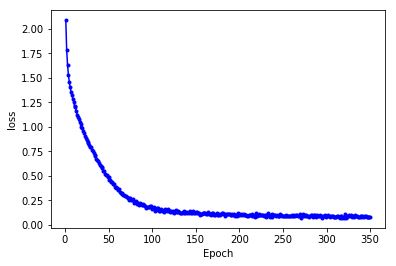

In [12]:
import matplotlib.pyplot as plt
max_epoch = 350
itern_axis_train = np.array(np.linspace(1,max_epoch,num=max_epoch))

plt.plot(itern_axis_train, loss,'-b.', label='Train')
plt.xlabel('Epoch')
plt.ylabel('loss')

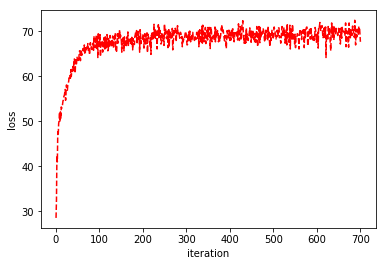

In [13]:
a = np.concatenate(acc_array)
length = a.shape[0]
a /= 100
acc_axis_test = np.array(np.linspace(1,length, num=length))
plt.plot(acc_axis_test, a.reshape(-1,1), '--r', label='Test')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(save_path + '/validation_accuracy' + str(max_epoch) + '.png')

using device: cuda
begin training
Checking accuracy on test set
Got 204 / 1000 correct (20.40)
1 epoch,   500 iteration, loss:2.278
Checking accuracy on test set
Got 225 / 1000 correct (22.50)
1 epoch,  1000 iteration, loss:2.187
 num 0 epoch 
####### Training Loss #######
[2.21077985]
Checking accuracy on test set
Got 272 / 1000 correct (27.20)
2 epoch,   500 iteration, loss:2.088
Checking accuracy on test set
Got 350 / 1000 correct (35.00)
2 epoch,  1000 iteration, loss:2.042
 num 1 epoch 
####### Training Loss #######
[2.04229618]
Checking accuracy on test set
Got 318 / 1000 correct (31.80)
3 epoch,   500 iteration, loss:1.962
Checking accuracy on test set
Got 367 / 1000 correct (36.70)
3 epoch,  1000 iteration, loss:1.904
 num 2 epoch 
####### Training Loss #######
[1.90382036]
Checking accuracy on test set
Got 394 / 1000 correct (39.40)
4 epoch,   500 iteration, loss:1.840
Checking accuracy on test set
Got 417 / 1000 correct (41.70)
4 epoch,  1000 iteration, loss:1.788
 num 3 epoc

Checking accuracy on test set
Got 675 / 1000 correct (67.50)
33 epoch,   500 iteration, loss:0.607
Checking accuracy on test set
Got 659 / 1000 correct (65.90)
33 epoch,  1000 iteration, loss:0.569
 num 32 epoch 
####### Training Loss #######
[0.57597492]
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
34 epoch,   500 iteration, loss:0.543
Checking accuracy on test set
Got 643 / 1000 correct (64.30)
34 epoch,  1000 iteration, loss:0.551
 num 33 epoch 
####### Training Loss #######
[0.53388961]
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
35 epoch,   500 iteration, loss:0.544
Checking accuracy on test set
Got 646 / 1000 correct (64.60)
35 epoch,  1000 iteration, loss:0.548
 num 34 epoch 
####### Training Loss #######
[0.54022706]
Checking accuracy on test set
Got 635 / 1000 correct (63.50)
36 epoch,   500 iteration, loss:0.536
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
36 epoch,  1000 iteration, loss:0.528
 num 35 epoch 
####### Training Lo

Got 661 / 1000 correct (66.10)
65 epoch,   500 iteration, loss:0.204
Checking accuracy on test set
Got 654 / 1000 correct (65.40)
65 epoch,  1000 iteration, loss:0.191
 num 64 epoch 
####### Training Loss #######
[0.19949999]
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
66 epoch,   500 iteration, loss:0.181
Checking accuracy on test set
Got 642 / 1000 correct (64.20)
66 epoch,  1000 iteration, loss:0.194
 num 65 epoch 
####### Training Loss #######
[0.19813137]
Checking accuracy on test set
Got 641 / 1000 correct (64.10)
67 epoch,   500 iteration, loss:0.205
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
67 epoch,  1000 iteration, loss:0.227
 num 66 epoch 
####### Training Loss #######
[0.21384067]
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
68 epoch,   500 iteration, loss:0.189
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
68 epoch,  1000 iteration, loss:0.184
 num 67 epoch 
####### Training Loss #######
[0.18560464]
Checki

Checking accuracy on test set
Got 685 / 1000 correct (68.50)
97 epoch,  1000 iteration, loss:0.141
 num 96 epoch 
####### Training Loss #######
[0.14251605]
Checking accuracy on test set
Got 638 / 1000 correct (63.80)
98 epoch,   500 iteration, loss:0.144
Checking accuracy on test set
Got 655 / 1000 correct (65.50)
98 epoch,  1000 iteration, loss:0.101
 num 97 epoch 
####### Training Loss #######
[0.12958036]
Checking accuracy on test set
Got 660 / 1000 correct (66.00)
99 epoch,   500 iteration, loss:0.138
Checking accuracy on test set
Got 673 / 1000 correct (67.30)
99 epoch,  1000 iteration, loss:0.114
 num 98 epoch 
####### Training Loss #######
[0.124078]
Checking accuracy on test set
Got 677 / 1000 correct (67.70)
100 epoch,   500 iteration, loss:0.130
Checking accuracy on test set
Got 640 / 1000 correct (64.00)
100 epoch,  1000 iteration, loss:0.112
 num 99 epoch 
####### Training Loss #######
[0.12283226]
Checking accuracy on test set
Got 633 / 1000 correct (63.30)
101 epoch,   5

Got 661 / 1000 correct (66.10)
129 epoch,   500 iteration, loss:0.079
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
129 epoch,  1000 iteration, loss:0.070
 num 128 epoch 
####### Training Loss #######
[0.07859035]
Checking accuracy on test set
Got 656 / 1000 correct (65.60)
130 epoch,   500 iteration, loss:0.092
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
130 epoch,  1000 iteration, loss:0.086
 num 129 epoch 
####### Training Loss #######
[0.08003168]
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
131 epoch,   500 iteration, loss:0.119
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
131 epoch,  1000 iteration, loss:0.080
 num 130 epoch 
####### Training Loss #######
[0.10261001]
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
132 epoch,   500 iteration, loss:0.081
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
132 epoch,  1000 iteration, loss:0.099
 num 131 epoch 
####### Training Loss #######
[0.0933

 num 159 epoch 
####### Training Loss #######
[0.09003157]
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
161 epoch,   500 iteration, loss:0.089
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
161 epoch,  1000 iteration, loss:0.071
 num 160 epoch 
####### Training Loss #######
[0.07404013]
Checking accuracy on test set
Got 664 / 1000 correct (66.40)
162 epoch,   500 iteration, loss:0.083
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
162 epoch,  1000 iteration, loss:0.083
 num 161 epoch 
####### Training Loss #######
[0.08836965]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
163 epoch,   500 iteration, loss:0.092
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
163 epoch,  1000 iteration, loss:0.070
 num 162 epoch 
####### Training Loss #######
[0.09065912]
Checking accuracy on test set
Got 664 / 1000 correct (66.40)
164 epoch,   500 iteration, loss:0.076
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
164

Got 663 / 1000 correct (66.30)
192 epoch,  1000 iteration, loss:0.095
 num 191 epoch 
####### Training Loss #######
[0.08219454]
Checking accuracy on test set
Got 658 / 1000 correct (65.80)
193 epoch,   500 iteration, loss:0.132
Checking accuracy on test set
Got 689 / 1000 correct (68.90)
193 epoch,  1000 iteration, loss:0.064
 num 192 epoch 
####### Training Loss #######
[0.09014949]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
194 epoch,   500 iteration, loss:0.079
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
194 epoch,  1000 iteration, loss:0.063
 num 193 epoch 
####### Training Loss #######
[0.06458527]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
195 epoch,   500 iteration, loss:0.111
Checking accuracy on test set
Got 663 / 1000 correct (66.30)
195 epoch,  1000 iteration, loss:0.061
 num 194 epoch 
####### Training Loss #######
[0.07889024]
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
196 epoch,   500 iteration, loss:

Checking accuracy on test set
Got 669 / 1000 correct (66.90)
224 epoch,  1000 iteration, loss:0.072
 num 223 epoch 
####### Training Loss #######
[0.07500361]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
225 epoch,   500 iteration, loss:0.096
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
225 epoch,  1000 iteration, loss:0.088
 num 224 epoch 
####### Training Loss #######
[0.08839882]
Checking accuracy on test set
Got 658 / 1000 correct (65.80)
226 epoch,   500 iteration, loss:0.103
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
226 epoch,  1000 iteration, loss:0.055
 num 225 epoch 
####### Training Loss #######
[0.07499506]
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
227 epoch,   500 iteration, loss:0.056
Checking accuracy on test set
Got 699 / 1000 correct (69.90)
227 epoch,  1000 iteration, loss:0.052
 num 226 epoch 
####### Training Loss #######
[0.05889051]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
228

Got 692 / 1000 correct (69.20)
256 epoch,   500 iteration, loss:0.057
Checking accuracy on test set
Got 659 / 1000 correct (65.90)
256 epoch,  1000 iteration, loss:0.096
 num 255 epoch 
####### Training Loss #######
[0.0896666]
Checking accuracy on test set
Got 656 / 1000 correct (65.60)
257 epoch,   500 iteration, loss:0.066
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
257 epoch,  1000 iteration, loss:0.072
 num 256 epoch 
####### Training Loss #######
[0.06543233]
Checking accuracy on test set
Got 661 / 1000 correct (66.10)
258 epoch,   500 iteration, loss:0.053
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
258 epoch,  1000 iteration, loss:0.068
 num 257 epoch 
####### Training Loss #######
[0.06677199]
Checking accuracy on test set
Got 630 / 1000 correct (63.00)
259 epoch,   500 iteration, loss:0.075
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
259 epoch,  1000 iteration, loss:0.064
 num 258 epoch 
####### Training Loss #######
[0.06710

 num 286 epoch 
####### Training Loss #######
[0.06819486]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
288 epoch,   500 iteration, loss:0.041
Checking accuracy on test set
Got 667 / 1000 correct (66.70)
288 epoch,  1000 iteration, loss:0.061
 num 287 epoch 
####### Training Loss #######
[0.05033919]
Checking accuracy on test set
Got 656 / 1000 correct (65.60)
289 epoch,   500 iteration, loss:0.081
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
289 epoch,  1000 iteration, loss:0.065
 num 288 epoch 
####### Training Loss #######
[0.06699356]
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
290 epoch,   500 iteration, loss:0.081
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
290 epoch,  1000 iteration, loss:0.095
 num 289 epoch 
####### Training Loss #######
[0.08763869]
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
291 epoch,   500 iteration, loss:0.052
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
291

Got 681 / 1000 correct (68.10)
319 epoch,  1000 iteration, loss:0.048
 num 318 epoch 
####### Training Loss #######
[0.0448185]
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
320 epoch,   500 iteration, loss:0.077
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
320 epoch,  1000 iteration, loss:0.094
 num 319 epoch 
####### Training Loss #######
[0.08120636]
Checking accuracy on test set
Got 697 / 1000 correct (69.70)
321 epoch,   500 iteration, loss:0.050
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
321 epoch,  1000 iteration, loss:0.033
 num 320 epoch 
####### Training Loss #######
[0.04696839]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
322 epoch,   500 iteration, loss:0.060
Checking accuracy on test set
Got 714 / 1000 correct (71.40)
322 epoch,  1000 iteration, loss:0.054
 num 321 epoch 
####### Training Loss #######
[0.05568686]
Checking accuracy on test set
Got 694 / 1000 correct (69.40)
323 epoch,   500 iteration, loss:0

now plotting accuracies and losses


ValueError: x and y must have same first dimension, but have shapes (1,) and (700,)

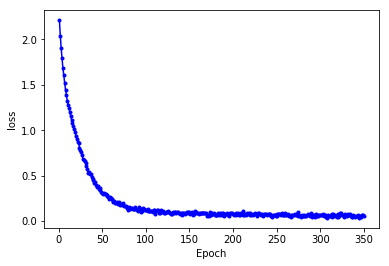

In [15]:
lr = [0.01, 0.005, 0.001, 0.0005]
epoch = [200, 250, 300] # first20

run_num = 10
net_name = 'ALL_CNN_C_Class1'

#torch.cuda.set_device(0)
all_cnn_c_class1 = new_ALL_Conv.ALL_CNN_C()
all_cnn_c_class1 = running_model_B(run_num, all_cnn_c_class1, net_name, lr, epoch, 
                        loaderA_train, loaderA_test)